## Loading Libraries

In [3]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import lightgbm as lgb
import networkx as nx
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [6]:
df. head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(4114680, 42)

## Basic Exploration 

In [8]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [9]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,64.1,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,NaN,92,303,OR


In [10]:
df.isna().sum()

Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64

In [11]:
df.drop(columns=["Avg Speed"], inplace=True)

In [12]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [13]:
df.isna().sum()

Timestamp                   0
Station                     0
Route                       0
Direction of Travel         0
Total Flow             303776
% Observed                  0
Samples                     0
Lane Type                   0
dtype: int64

In [14]:
df = df[df['Total Flow'].notna()]

In [15]:
df.isna().sum()

Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64

In [16]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [17]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

In [18]:
df.duplicated().sum()

0

In [19]:
df.reset_index().duplicated(subset=['Timestamp', 'Station']).sum()

0

In [20]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [21]:
# Convert Station to categorical type
df['Station'] = df['Station'].astype('category')

In [22]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01,308512,50,W,497.0,0,197,ML
2024-10-01,311831,5,S,27.0,92,101,OR
2024-10-01,311832,5,S,78.0,92,101,FR
2024-10-01,311844,5,N,43.0,92,202,OR
2024-10-01,311847,5,N,73.0,92,303,OR


## Feature Engineering

In [23]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [24]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [25]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [26]:
df['Flow_roll_mean_6h'] = df['Total Flow'].rolling(window=6).mean()
df['Flow_roll_std_6h'] = df['Total Flow'].rolling(window=6).std()
df['Flow_roll_max_6h'] = df['Total Flow'].rolling(window=6).max()
df['Flow_roll_min_6h'] = df['Total Flow'].rolling(window=6).min()

In [27]:
for window in [3, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

In [28]:
df.dropna(inplace=True)

In [29]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [30]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,1068.0,395.833333,570.838627,3.0,3419.0,435.736111,522.596712,3.0,3419.0,0
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,1068.0,399.458333,568.924516,3.0,3419.0,437.486111,521.544267,3.0,3419.0,0
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,1068.0,404.375000,571.276906,3.0,3419.0,440.069444,522.824677,3.0,3419.0,0
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,1068.0,426.000000,575.736716,3.0,3419.0,443.555556,526.078366,3.0,3419.0,0
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1068.0,376.937500,383.507686,3.0,1525.0,457.500000,529.066225,3.0,3419.0,0


In [31]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

In [32]:
df.dropna(inplace=True)

In [33]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

## Basic Graphical Exploration

In [34]:
df['IsHoliday'] = df['IsHoliday'].astype('category')
df['Route'] = df['Route'].astype('category')

In [35]:
#  Keep only numeric features
numeric_df = df.select_dtypes(include='number')

In [36]:
cat_features = [
    'Station', 'Route', 'Direction of Travel', 'Lane Type',
    'Weekday', 'IsWeekend', 'IsHoliday'
]

for col in cat_features:
    df[col] = df[col].astype('category')

In [37]:
# Define target and features
target = 'Total Flow'
features = [col for col in df.columns if col != target]

In [38]:
# Final feature groups
flow_features = [
    'Flow_mean_3', 'Flow_std_3', 'Flow_max_3', 'Flow_min_3',
    'Flow_mean_72', 'Flow_std_72', 'Flow_std_48', 'Flow_max_24',
    'Flow_mean_24', 'Flow_mean_48',
    'Flow_roll_std_6h', 'Flow_roll_max_6h',
    'Flow_CV_48'
]

lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8',
    'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

time_features = [
    'Hour', 'Hour_cos', 'Hour_sin', 'Weekday_cos'
]

quality_features = [
    'Samples', '% Observed'
]

# Copy original DataFrame
df_model = df.copy()

# One-hot encode low-cardinality features
df_model = pd.get_dummies(df_model, columns=['IsHoliday', 'Direction of Travel'], drop_first=True)

# Label encode high-cardinality categorical features
for col in ['Station', 'Route', 'Lane Type']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Capture dummy columns dynamically
dummy_columns = [col for col in df_model.columns if col.startswith('IsHoliday_') or col.startswith('Direction of Travel_')]

# Final feature list
categorical_features = ['Lane Type', 'Route', 'Station']
selected_features = flow_features + lag_features + time_features + quality_features + categorical_features + dummy_columns


In [39]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday,Flow_CV_12,Flow_CV_24,Flow_CV_48,Flow_CV_72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,3419.0,435.736111,522.596712,3.0,3419.0,0,0.581854,0.884330,1.442119,1.199342
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,3419.0,437.486111,521.544267,3.0,3419.0,0,0.648914,0.895621,1.424240,1.192139
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,3419.0,440.069444,522.824677,3.0,3419.0,0,0.534337,0.827111,1.412740,1.188050
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,3419.0,443.555556,526.078366,3.0,3419.0,0,0.530732,0.817180,1.351495,1.186048
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1525.0,457.500000,529.066225,3.0,3419.0,0,0.545745,0.772216,1.017430,1.156429


In [40]:
pivot_df = df.pivot(columns='Station', values='Total Flow')

pivot_df = pivot_df.sort_index()

In [41]:
missing_summary = pivot_df.isnull().sum()
print("Missing values per station:\n", missing_summary)

Missing values per station:
 Station
308511     3
308512     1
311831     2
311832     2
311844     2
          ..
3423094    0
3900021    0
3900022    0
3900023    0
3900024    0
Length: 1806, dtype: int64


In [42]:
pivot_df = pivot_df.fillna(method='ffill')       # Forward fill
pivot_df = pivot_df.fillna(method='bfill')       # Backward fill
pivot_df = pivot_df.interpolate(method='time')   # Time-based interpolation


display(pivot_df.head())

Station,308511,308512,311831,311832,311844,311847,311903,311930,311973,311974,...,3423063,3423064,3423065,3423066,3423091,3423094,3900021,3900022,3900023,3900024
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,12.0,489.0,24.0,44.0,25.0,59.0,1085.0,429.0,23.0,725.0,...,2.0,2632.0,2.0,3.0,75.0,0.0,556.0,320.0,546.0,320.0
2024-10-01 01:00:00,12.0,489.0,24.0,44.0,25.0,59.0,1085.0,429.0,23.0,725.0,...,3.0,2824.0,1.0,3.0,47.0,20.0,520.0,225.0,505.0,225.0
2024-10-01 02:00:00,12.0,473.0,21.0,26.0,40.0,28.0,960.0,321.0,15.0,611.0,...,3.0,3184.0,4.0,3.0,43.0,27.0,482.0,201.0,519.0,201.0
2024-10-01 03:00:00,20.0,503.0,34.0,27.0,68.0,63.0,988.0,451.0,10.0,749.0,...,2.0,3263.0,1.0,3.0,61.0,15.0,522.0,246.0,583.0,246.0
2024-10-01 04:00:00,55.0,687.0,56.0,44.0,121.0,87.0,1325.0,1059.0,24.0,1514.0,...,18.0,3654.0,6.0,3.0,153.0,79.0,649.0,446.0,915.0,446.0


In [100]:
def generate_multistation_dataset(data, input_length, forecast_horizon):
    X, Y = [], []
    for t in range(len(data) - input_length - forecast_horizon + 1):
        X.append(data[t : t + input_length])
        Y.append(data[t + input_length + forecast_horizon - 1])
    return np.array(X), np.array(Y)


In [101]:
horizon_configs = {
    "12h": (24, 12),
    "24h": (24, 24),
    "48h": (24, 48),
    "72h": (24, 72),
}

# Generate datasets
datasets = {k: generate_multistation_dataset(pivot_df.values, *v) for k, v in horizon_configs.items()}


In [102]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data_per_station(X, Y):
    time_steps, num_stations = X.shape[1], X.shape[2]
    
    X_reshaped = X.reshape(-1, num_stations)
    scaler_X = MinMaxScaler().fit(X_reshaped)
    X_scaled = scaler_X.transform(X_reshaped).reshape(-1, time_steps, num_stations)

    Y_reshaped = Y.reshape(-1, num_stations)
    scaler_Y = MinMaxScaler().fit(Y_reshaped)
    Y_scaled = scaler_Y.transform(Y_reshaped).reshape(-1, num_stations)

    return X_scaled, Y_scaled, scaler_X, scaler_Y


In [103]:
X_12, Y_12 = datasets["12h"]
X_24, Y_24 = datasets["24h"]
X_48, Y_48 = datasets["48h"]
X_72, Y_72 = datasets["72h"]

X_12_scaled, Y_12_scaled, X_scaler_12, Y_scaler_12 = normalize_data_per_station(X_12, Y_12)
X_24_scaled, Y_24_scaled, X_scaler_24, Y_scaler_24 = normalize_data_per_station(X_24, Y_24)
X_48_scaled, Y_48_scaled, X_scaler_48, Y_scaler_48 = normalize_data_per_station(X_48, Y_48)
X_72_scaled, Y_72_scaled, X_scaler_72, Y_scaler_72 = normalize_data_per_station(X_72, Y_72)


In [105]:
from sklearn.model_selection import train_test_split

# 12-hour horizon
X_train_12, X_temp_12, Y_train_12, Y_temp_12 = train_test_split(X_12_scaled, Y_12_scaled, test_size=0.3, random_state=42)
X_val_12, X_test_12, Y_val_12, Y_test_12 = train_test_split(X_temp_12, Y_temp_12, test_size=0.5, random_state=42)

# 24-hour horizon
X_train_24, X_temp_24, Y_train_24, Y_temp_24 = train_test_split(X_24_scaled, Y_24_scaled, test_size=0.3, random_state=42)
X_val_24, X_test_24, Y_val_24, Y_test_24 = train_test_split(X_temp_24, Y_temp_24, test_size=0.5, random_state=42)

# 48-hour horizon
X_train_48, X_temp_48, Y_train_48, Y_temp_48 = train_test_split(X_48_scaled, Y_48_scaled, test_size=0.3, random_state=42)
X_val_48, X_test_48, Y_val_48, Y_test_48 = train_test_split(X_temp_48, Y_temp_48, test_size=0.5, random_state=42)

# 72-hour horizon
X_train_72, X_temp_72, Y_train_72, Y_temp_72 = train_test_split(X_72_scaled, Y_72_scaled, test_size=0.3, random_state=42)
X_val_72, X_test_72, Y_val_72, Y_test_72 = train_test_split(X_temp_72, Y_temp_72, test_size=0.5, random_state=42)

# Optional: confirm shapes
print("Final Splits (12h):", X_train_12.shape, X_val_12.shape, X_test_12.shape)
print("Final Splits (24h):", X_train_24.shape, X_val_24.shape, X_test_24.shape)
print("Final Splits (48h):", X_train_48.shape, X_val_48.shape, X_test_48.shape)
print("Final Splits (72h):", X_train_72.shape, X_val_72.shape, X_test_72.shape)


Final Splits (12h): (1521, 24, 1806) (326, 24, 1806) (326, 24, 1806)
Final Splits (24h): (1512, 24, 1806) (324, 24, 1806) (325, 24, 1806)
Final Splits (48h): (1495, 24, 1806) (321, 24, 1806) (321, 24, 1806)
Final Splits (72h): (1479, 24, 1806) (317, 24, 1806) (317, 24, 1806)


In [106]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 64

# Utility function to create DataLoaders
def prepare_dataloaders(X_train, Y_train, X_val, Y_val, batch_size=64):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size)

    return train_loader, val_loader

# 12h
train_loader_12, val_loader_12 = prepare_dataloaders(X_train_12, Y_train_12, X_val_12, Y_val_12)

# 24h
train_loader_24, val_loader_24 = prepare_dataloaders(X_train_24, Y_train_24, X_val_24, Y_val_24)

# 48h
train_loader_48, val_loader_48 = prepare_dataloaders(X_train_48, Y_train_48, X_val_48, Y_val_48)

# 72h
train_loader_72, val_loader_72 = prepare_dataloaders(X_train_72, Y_train_72, X_val_72, Y_val_72)


Using device: cpu


In [107]:
import torch
import torch.nn as nn

# === 1. Define the Hybrid Model ===
class CNN_GRU_LSTM(nn.Module):
    def __init__(self, num_stations, cnn_filters=64, gru_hidden=64, lstm_hidden=64, dropout=0.3):
        super(CNN_GRU_LSTM, self).__init__()
        self.num_stations = num_stations

        # CNN Block: (batch, stations, time_steps) --> (batch, filters, time_steps)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_stations, out_channels=cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # GRU Block: (batch, time_steps, features)
        self.gru = nn.GRU(input_size=cnn_filters, hidden_size=gru_hidden, num_layers=2,
                          batch_first=True, dropout=dropout)

        # LSTM Block: (batch, time_steps, gru_hidden)
        self.lstm = nn.LSTM(input_size=gru_hidden, hidden_size=lstm_hidden, num_layers=2,
                            batch_first=True, dropout=dropout)

        # Fully Connected
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_stations)  # predict per station
        )

    def forward(self, x):
        # Input: (batch, time_steps, num_stations)
        batch_size, time_steps, num_stations = x.size()

        # CNN: needs (batch, num_stations, time_steps)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)  # (batch, cnn_filters, time_steps)

        # GRU: needs (batch, time_steps, features)
        x = x.permute(0, 2, 1)
        x, _ = self.gru(x)

        # LSTM
        x, _ = self.lstm(x)

        # Use last time step only
        x = x[:, -1, :]  # (batch, lstm_hidden)

        return self.fc(x)  # (batch, num_stations)


# === 2. Instantiate for Each Horizon ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_stations = 1806

model_12 = CNN_GRU_LSTM(num_stations=num_stations).to(device)
model_24 = CNN_GRU_LSTM(num_stations=num_stations).to(device)
model_48 = CNN_GRU_LSTM(num_stations=num_stations).to(device)
model_72 = CNN_GRU_LSTM(num_stations=num_stations).to(device)


In [108]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.HuberLoss()
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = loss_fn(preds, yb)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [109]:
# 12-hour forecast
print("\n Training model for 12h forecast")
train_losses_12, val_losses_12 = train_model(model_12, train_loader_12, val_loader_12, num_epochs=20)

# 24-hour forecast
print("\n Training model for 24h forecast")
train_losses_24, val_losses_24 = train_model(model_24, train_loader_24, val_loader_24, num_epochs=20)

# 48-hour forecast
print("\n Training model for 48h forecast")
train_losses_48, val_losses_48 = train_model(model_48, train_loader_48, val_loader_48, num_epochs=20)

# 72-hour forecast
print("\n Training model for 72h forecast")
train_losses_72, val_losses_72 = train_model(model_72, train_loader_72, val_loader_72, num_epochs=20)



 Training model for 12h forecast
Epoch 1/20 | Train Loss: 0.0602 | Val Loss: 0.0309
Epoch 2/20 | Train Loss: 0.0304 | Val Loss: 0.0182
Epoch 3/20 | Train Loss: 0.0152 | Val Loss: 0.0105
Epoch 4/20 | Train Loss: 0.0113 | Val Loss: 0.0074
Epoch 5/20 | Train Loss: 0.0102 | Val Loss: 0.0071
Epoch 6/20 | Train Loss: 0.0094 | Val Loss: 0.0064
Epoch 7/20 | Train Loss: 0.0086 | Val Loss: 0.0066
Epoch 8/20 | Train Loss: 0.0083 | Val Loss: 0.0057
Epoch 9/20 | Train Loss: 0.0079 | Val Loss: 0.0056
Epoch 10/20 | Train Loss: 0.0076 | Val Loss: 0.0055
Epoch 11/20 | Train Loss: 0.0076 | Val Loss: 0.0055
Epoch 12/20 | Train Loss: 0.0071 | Val Loss: 0.0052
Epoch 13/20 | Train Loss: 0.0069 | Val Loss: 0.0054
Epoch 14/20 | Train Loss: 0.0066 | Val Loss: 0.0049
Epoch 15/20 | Train Loss: 0.0065 | Val Loss: 0.0050
Epoch 16/20 | Train Loss: 0.0063 | Val Loss: 0.0048
Epoch 17/20 | Train Loss: 0.0062 | Val Loss: 0.0047
Epoch 18/20 | Train Loss: 0.0058 | Val Loss: 0.0044
Epoch 19/20 | Train Loss: 0.0059 | Val 

In [110]:
import pandas as pd

df_losses = pd.DataFrame({
    "Epoch": list(range(1, 21)),
    "Train_12h": train_losses_12,
    "Val_12h": val_losses_12,
    "Train_24h": train_losses_24,
    "Val_24h": val_losses_24,
    "Train_48h": train_losses_48,
    "Val_48h": val_losses_48,
    "Train_72h": train_losses_72,
    "Val_72h": val_losses_72,
})

df_losses.to_excel("cnn_gru_lstm_loss_history.xlsx", index=False)
print(" Saved loss history to cnn_gru_lstm_loss_history.xlsx")


 Saved loss history to cnn_gru_lstm_loss_history.xlsx


In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_save(model, X_test, Y_test, Y_scaler, horizon_label, station_names):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        Y_pred_scaled = model(X_tensor).cpu().numpy()

    # Inverse transform predictions and true labels
    Y_pred = Y_scaler.inverse_transform(Y_pred_scaled)
    Y_true = Y_scaler.inverse_transform(Y_test)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(Y_true.flatten(), Y_pred.flatten()))
    mae = mean_absolute_error(Y_true.flatten(), Y_pred.flatten())

    print(f"\n Evaluation for {horizon_label} Forecast")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")

    # Save to Excel
    df_pred = pd.DataFrame(Y_pred, columns=station_names)
    df_true = pd.DataFrame(Y_true, columns=station_names)
    df_combined = pd.concat([df_true.add_prefix("True_"), df_pred.add_prefix("Pred_")], axis=1)
    df_combined.to_excel(f"cnn_gru_lstm_{horizon_label}_predictions.xlsx", index=False)

    print(f" Saved predictions to cnn_gru_lstm_{horizon_label}_predictions.xlsx")

    return rmse, mae


In [115]:
# Station names from original DataFrame
station_names = pivot_df.columns

rmse_mae_results = {}

rmse_mae_results["12h"] = evaluate_and_save(
    model_12, X_test_12, Y_test_12, Y_scaler_12, "12h", station_names)

rmse_mae_results["24h"] = evaluate_and_save(
    model_24, X_test_24, Y_test_24, Y_scaler_24, "24h", station_names)

rmse_mae_results["48h"] = evaluate_and_save(
    model_48, X_test_48, Y_test_48, Y_scaler_48, "48h", station_names)

rmse_mae_results["72h"] = evaluate_and_save(
    model_72, X_test_72, Y_test_72, Y_scaler_72, "72h", station_names)



 Evaluation for 12h Forecast
RMSE: 253.95
MAE : 133.50
 Saved predictions to cnn_gru_lstm_12h_predictions.xlsx

 Evaluation for 24h Forecast
RMSE: 241.41
MAE : 124.32
 Saved predictions to cnn_gru_lstm_24h_predictions.xlsx

 Evaluation for 48h Forecast
RMSE: 280.81
MAE : 150.00
 Saved predictions to cnn_gru_lstm_48h_predictions.xlsx

 Evaluation for 72h Forecast
RMSE: 326.84
MAE : 171.02
 Saved predictions to cnn_gru_lstm_72h_predictions.xlsx


In [116]:
df_metrics = pd.DataFrame([
    {"Horizon": k, "RMSE": v[0], "MAE": v[1]} for k, v in rmse_mae_results.items()
])
df_metrics.to_excel("cnn_gru_lstm_forecast_metrics.xlsx", index=False)
print(" Saved summary metrics to cnn_gru_lstm_forecast_metrics.xlsx")


 Saved summary metrics to cnn_gru_lstm_forecast_metrics.xlsx


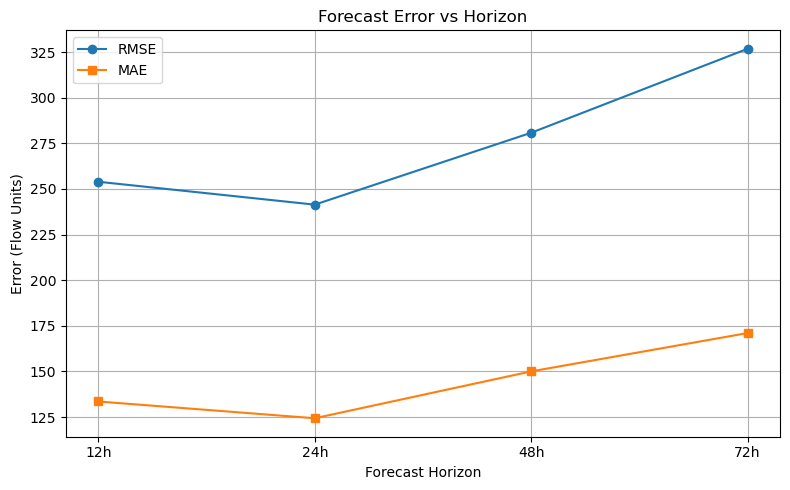

In [118]:
import matplotlib.pyplot as plt

# You can use this if you already ran Step 10
horizons = ["12h", "24h", "48h", "72h"]
rmse_vals = [rmse_mae_results[h][0] for h in horizons]
mae_vals = [rmse_mae_results[h][1] for h in horizons]

plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_vals, marker='o', label='RMSE')
plt.plot(horizons, mae_vals, marker='s', label='MAE')
plt.title("Forecast Error vs Horizon")
plt.xlabel("Forecast Horizon")
plt.ylabel("Error (Flow Units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecast_error_vs_horizon.png", dpi=300)
plt.show()

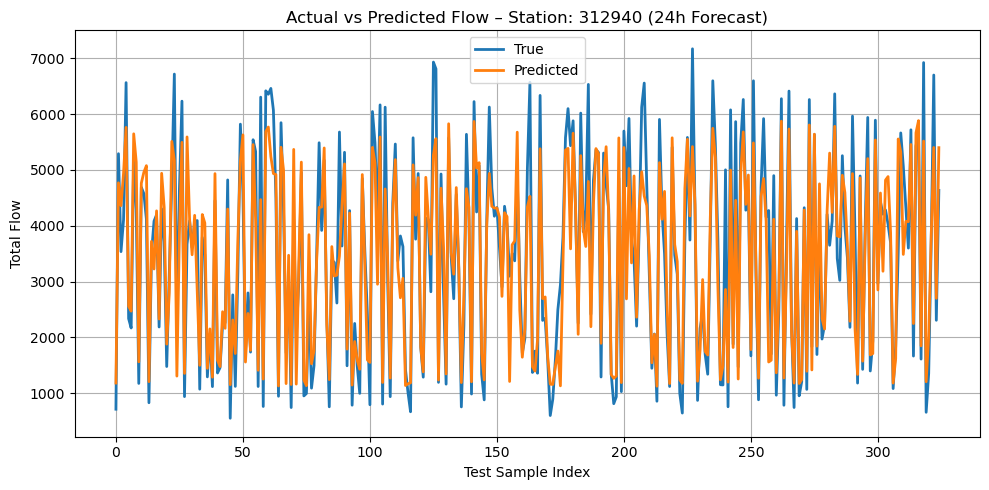

In [120]:
station_index = 100  # pick an index (0–1805) or choose based on performance
station_name = pivot_df.columns[station_index]

true_series = Y_true_24h[:, station_index]
pred_series = Y_pred_24h[:, station_index]

plt.figure(figsize=(10, 5))
plt.plot(true_series, label="True", linewidth=2)
plt.plot(pred_series, label="Predicted", linewidth=2)
plt.title(f"Actual vs Predicted Flow – Station: {station_name} (24h Forecast)")
plt.xlabel("Test Sample Index")
plt.ylabel("Total Flow")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"actual_vs_predicted_{station_name}_24h.png", dpi=300)
plt.show()
